In [1]:
#importar librerias necesarias
from mesa import Agent, Model 

#necesitamos que al inicio esten todos los robots en el mismo punto
from mesa.space import MultiGrid
from mesa.space import SingleGrid

#todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

#obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

import numpy as np
import pandas as pd
import time
import datetime

In [2]:
height = 0
width = 0
puntoGeneracion = (0, 0)
mapaInicial = []
mapaActual = []

In [3]:
def leerTxt():
  global height, width, puntoGeneracion
  archivo = "mapaTest.txt"
  matriz = []

  with open(archivo, 'r') as f:
      lineas = f.readlines()

  # Obtener las dimensiones de la matriz
  dimensiones = lineas[0].split()
  height = int(dimensiones[0])
  width = int(dimensiones[1])
    
  # Construir la matriz
  for linea in lineas[1:]:
      fila = linea.split()
      matriz.append(fila)
  
  for i in range(height):
      for j in range(width):
          if matriz[i][j] == 'S':
              puntoGeneracion = (i, j)

  # Retorna la matriz
  return matriz

In [4]:
def inicializar():
    global mapaInicial, mapaActual
    mapaActual = []
    mapaInicial = leerTxt()
    
    for i in range(len(mapaInicial)):
        mapaActual.append([])
        for j in range(len(mapaInicial[i])):
            if mapaInicial[i][j] == 'P' or mapaInicial[i][j] == 'S':
                mapaActual[i].append(mapaInicial[i][j]);
            else:
                mapaActual[i].append(0);

In [5]:
def escanear(x, y):    
    #actualizar visitado
    if mapaInicial[x][y] == '0' or mapaInicial[x][y] == 'S':
            mapaInicial[x][y] = 'V'            
    
    #escanear al rededor    
    
    if x == 0:
        mapaActual[x + 1][y] = mapaInicial[x + 1][y]
    elif x > 0:
        if x == height - 1:
            mapaActual[x - 1][y] = mapaInicial[x - 1][y]
        elif x < height - 1:
            mapaActual[x + 1][y] = mapaInicial[x + 1][y]
            mapaActual[x - 1][y] = mapaInicial[x - 1][y]

    if y == 0:
        mapaActual[x][y + 1] = mapaInicial[x][y + 1]
    elif y > 0:
        if y == width - 1:
            mapaActual[x][y - 1] = mapaInicial[x][y - 1]
        elif y < width - 1:
            mapaActual[x][y + 1] = mapaInicial[x][y + 1]
            mapaActual[x][y - 1] = mapaInicial[x][y - 1]
    
    if y == 0 and x == 0:
        mapaActual[x + 1][y + 1] = mapaInicial[x + 1][y + 1]
    else:
        if y == (width - 1) or x == (height - 1):
            if x == height - 1 and y == width - 1:                
                mapaActual[x - 1][y - 1] = mapaInicial[x - 1][y - 1]
            elif x == height - 1:                
                mapaActual[x - 1][y + 1] = mapaInicial[x - 1][y + 1]
                mapaActual[x - 1][y - 1] = mapaInicial[x - 1][y - 1]
            else:
                mapaActual[x + 1][y - 1] = mapaInicial[x + 1][y - 1]
                mapaActual[x - 1][y - 1] = mapaInicial[x - 1][y - 1]
        elif x > 0 and y > 0:            
            mapaActual[x + 1][y + 1] = mapaInicial[x + 1][y + 1]
            mapaActual[x - 1][y + 1] = mapaInicial[x - 1][y + 1]
            mapaActual[x + 1][y - 1] = mapaInicial[x + 1][y - 1]
            mapaActual[x - 1][y - 1] = mapaInicial[x - 1][y - 1]    

In [57]:
class RobotExplorador(Agent):
    def __init__(self, id, model, capacidad=5, rol = 0):
        super().__init__(id, model)
        self.id = id
        self.capacidad = capacidad
        self.rol = rol
        
    def step(self):
        x, y = self.pos
        escanear(x,y)

        #basura recoger
        try:
            valor = int(mapaActual[x][y])
            if valor > 0 and self.capacidad > 0:
                #print("recogio" + str(self.id))
                if valor <= self.capacidad:
                    self.capacidad -= valor
                    mapaActual[x][y] = '0'
                    mapaInicial[x][y] = '0'
                else:
                    mapaActual[x][y] = str(valor - self.capacidad)
                    mapaInicial[x][y] = str(valor - self.capacidad)
                    self.capacidad = 0                
        except ValueError:
            #print("No es numero")
            valor = 0
            
        possible_moves = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False
        )        
        
        empty_cells = [cell for cell in possible_moves if self.model.grid.is_cell_empty(cell) and mapaActual[cell[0]][cell[1]] != 'X' and mapaActual[cell[0]][cell[1]] != 'P']
        trash_cells = [cell for cell in possible_moves if self.model.grid.is_cell_empty(cell) and isinstance(mapaActual[x][y], int)]
        noVisitedCells = [cell for cell in possible_moves if self.model.grid.is_cell_empty(cell) and mapaActual[cell[0]][cell[1]] != 'X' and mapaActual[cell[0]][cell[1]] != 'P' and mapaActual[cell[0]][cell[1]] != 'V']
        papelera_cell = [cell for cell in possible_moves if self.model.grid.is_cell_empty(cell) and mapaActual[cell[0]][cell[1]] == 'P']

        if self.capacidad < 5:
            if papelera_cell:                
                self.capacidad = 5
                #print("dejo" + str(self.id))
            if empty_cells:
                new_position = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, new_position)
        else:
            if trash_cells:                
                self.model.grid.move_agent(self, trash_cells[0])
            elif noVisitedCells:
                self.model.grid.move_agent(self, noVisitedCells[0])
            elif empty_cells:
                new_position = self.random.choice(empty_cells)
                self.model.grid.move_agent(self, new_position)

In [58]:
def get_grid(model):
    grid = np.zeros( (model.grid.width, model.grid.height) )    
    for (content, (x, y)) in model.grid.coord_iter():
        if content:
            grid[x][y] = 100 + content[0].id
        else:
            if mapaActual[x][y] == 'X':
                grid[x][y] = 200
            elif mapaActual[x][y] == 'P':
                grid[x][y] = 300
            elif mapaActual[x][y] == 'V':
                grid[x][y] = 400
            else:
                grid[x][y] = mapaActual[x][y]
    #print(grid)
    return grid

In [59]:
class EspacioModel(Model):
    def __init__(self, width, height):
        self.grid = MultiGrid(width, height, torus = False)
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(model_reporters = {"Grid": get_grid})

        id = 0
        num_agents = 5        
        while self.grid.exists_empty_cells():
            agent = RobotExplorador(id, self)            
            self.grid.place_agent(agent, puntoGeneracion)
            self.schedule.add(agent)
            id += 1
            if id >= num_agents:
                break
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [64]:
inicializar()
iterations = 0

model = EspacioModel(height, width)

while True: 
    model.step()
    iterations += 1
    doBreak = False
    #comprobar terminado
    for x in range(len(mapaActual)):        
        for y in range(len(mapaActual[x])):
            try:
                valor = int(mapaActual[x][y])
                if valor > 0:
                    doBreak = True
                    break
            except ValueError:
                valor = 0
        if doBreak:
            break

    if not doBreak:
        break


print("Iteraciones: " + str(iterations))
print("Mapa: ")
print(mapaActual)

Iteraciones: 485
Mapa: 
[['V', 'V', 'V', 'V', 'V', 'V', '0'], ['V', 'X', 'V', 'V', 'V', 'V', 'V'], ['V', 'V', 'V', 'V', 'V', 'V', 'V'], ['V', 'X', 'V', 'V', 'V', 'V', 'V'], ['V', 'X', 'V', 'V', 'V', 'V', 'V'], ['V', 'V', 'P', 'X', 'V', 'V', 'V'], ['V', 'V', 'V', 'V', 'V', 'V', 'V'], ['V', 'X', 'V', 'V', 'V', 'V', 'V'], ['V', 'V', 'V', 'V', 'V', 'V', 'V'], ['V', 'V', 'V', 'X', 'V', 'X', 'V'], ['V', 'V', 'X', 'V', 'V', 'V', 'V'], ['V', 'V', 'V', 'V', 'V', 'V', 'V'], ['V', 'V', 'V', 'X', 'V', 'V', 'V']]


                                                  Grid
0    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....
1    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....
2    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....
3    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....
4    [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0....
..                                                 ...
480  [[400.0, 400.0, 400.0, 400.0, 400.0, 400.0, 1....
481  [[400.0, 400.0, 400.0, 400.0, 400.0, 103.0, 1....
482  [[400.0, 400.0, 400.0, 400.0, 400.0, 400.0, 1....
483  [[400.0, 400.0, 400.0, 400.0, 400.0, 400.0, 1....
484  [[400.0, 400.0, 400.0, 400.0, 400.0, 400.0, 10...

[485 rows x 1 columns]
[[[1, 2, 3], [1, 2, 3], [1, 2, 3]], [[1, 2, 3], [1, 2, 3], [1, 2, 3]], [[1, 2, 3], [1, 2, 3], [1, 2, 3]]]


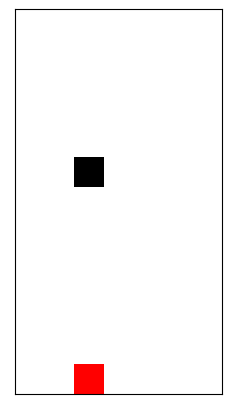

In [68]:
all_grid = model.datacollector.get_model_vars_dataframe()
print(all_grid)
position = [[[1, 2, 3], [1, 2, 3], [1, 2, 3]],[[1, 2, 3], [1, 2, 3], [1, 2, 3]],[[1, 2, 3], [1, 2, 3], [1, 2, 3]]]
print(position)
color_map = {
    0: 'white',  
    1000: 'blue',   
    2000: 'red',
    3000: 'green',
    4000: 'yellow',
    5000: 'black'
}
fig, axis = plt.subplots(figsize=(5, 5))
axis.set_xticks([])
axis.set_yticks([])

patch = plt.imshow(all_grid.iloc[0][0], cmap=plt.cm.colors.ListedColormap([color_map[val] for val in color_map]))

def animate(i):
    patch.set_data(all_grid.iloc[i][0])

anim = animation.FuncAnimation(fig, animate, frames=MAX_ITERATIONS)
anim